# 19기 KNN 정규세션 과제

**데이터:** [blackfriday | Kaggle](https://www.kaggle.com/llopesolivei/blackfriday)

---

In [51]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.metrics import *
import optuna
from optuna.samplers import TPESampler
import joblib

## 0. 데이터 불러오기

In [26]:
import pandas as pd
df = pd.read_csv("blackfriday.csv", index_col = 0)
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1001088,P00046042,F,0-17,10,A,3,0,5,17.0,NaN,2010
1,1004493,P00347742,F,0-17,10,A,1,0,7,NaN,NaN,4483
2,1005302,P00048942,F,0-17,10,A,1,0,1,4.0,NaN,7696
3,1001348,P00145242,F,0-17,10,A,3,0,2,4.0,NaN,16429
4,1001348,P00106742,F,0-17,10,A,3,0,3,5.0,NaN,5780


데이터에 대한 정보를 따로 찾아본 결과 해당 데이터는 미국의 BlackFriday 기간에 제품을 구매한 고객에 관한 정보이며, 변수에 대한 설명은 다음과 같습니다.

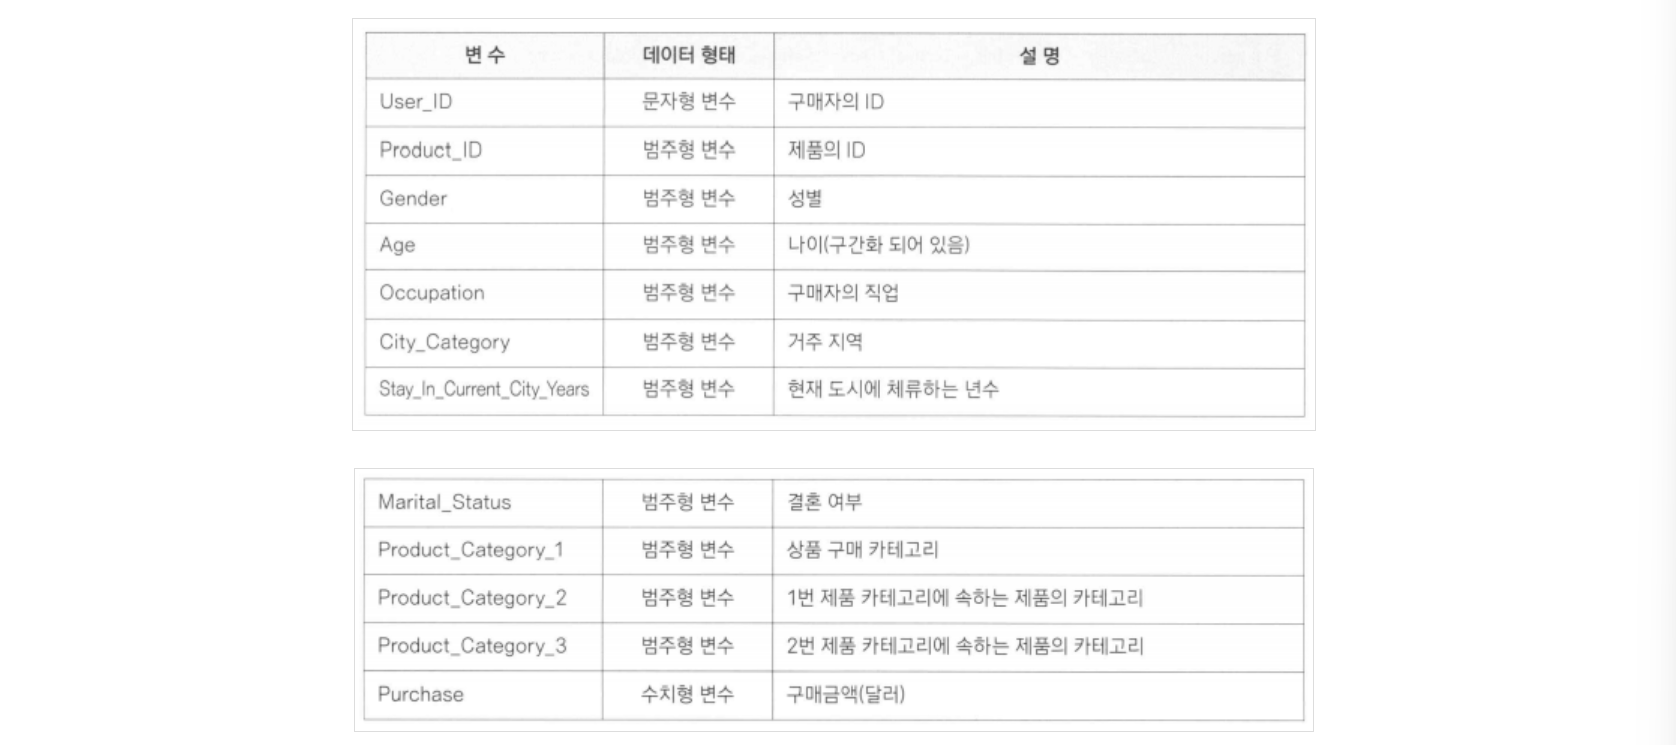

## 1. Preprocssing

In [27]:
df.duplicated().sum()

0

In [28]:
df.isnull().sum()/len(df)

User_ID                       0.000000
Product_ID                    0.000000
Gender                        0.000000
Age                           0.000000
Occupation                    0.000000
City_Category                 0.000000
Stay_In_Current_City_Years    0.000000
Marital_Status                0.000000
Product_Category_1            0.000000
Product_Category_2            0.306723
Product_Category_3            0.691076
Purchase                      0.000000
dtype: float64

In [29]:
df['Product_Category_1'].unique()

array([ 5,  7,  1,  2,  3,  8, 16, 14, 10, 19, 11, 12,  4, 17, 15,  6, 13,
       20, 18,  9], dtype=int64)

In [30]:
df['Product_Category_2'].unique()

array([17., nan,  4.,  5., 15.,  8., 12., 11.,  2., 14.,  3., 18., 16.,
        6., 13., 10.,  9.,  7.])

중복값은 없지만 Product_Category_2, Product_Category_3 의 경우 결측 비율이 0.3, 0.69 입니다. 해당 칼럼들은 Product_Category_1의 하위 카테고리 이므로 하위 카테고리가 존재하지 않음을 표현해주기 위해 우선 -1로 결측치를 채워주고 이후 모델 성능에 영향이 클경우 제거하도록 하겠습니다.

In [31]:
df = df.fillna(-1)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4998 entries, 0 to 4997
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   User_ID                     4998 non-null   int64  
 1   Product_ID                  4998 non-null   object 
 2   Gender                      4998 non-null   object 
 3   Age                         4998 non-null   object 
 4   Occupation                  4998 non-null   int64  
 5   City_Category               4998 non-null   object 
 6   Stay_In_Current_City_Years  4998 non-null   object 
 7   Marital_Status              4998 non-null   int64  
 8   Product_Category_1          4998 non-null   int64  
 9   Product_Category_2          4998 non-null   float64
 10  Product_Category_3          4998 non-null   float64
 11  Purchase                    4998 non-null   int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 507.6+ KB


In [17]:
df['User_ID'].nunique()

2656

In [13]:
df['Product_ID'].nunique()

1797

In [33]:
df = df.drop(columns = ['User_ID','Product_ID'])

유저/제품 아이디의 경우 제거하겠습니다.

그 외의 오브젝트 타입은 원핫인코딩을 해주겠습니다.

In [34]:
df['Age'].unique()

array(['0-17', '18-25', '26-35', '36-45', '46-50', '51-55', '55+'],
      dtype=object)

In [35]:
df['Gender'].unique()

array(['F', 'M'], dtype=object)

In [36]:
df['City_Category'].unique()

array(['A', 'B', 'C'], dtype=object)

In [37]:
df['Stay_In_Current_City_Years'].unique()

array(['3', '1', '2', '4+', '0'], dtype=object)

In [38]:
df.loc[(df['Gender']=='M'), 'Gender'] = 1
df.loc[(df['Gender']=='F'), 'Gender'] = 0

In [39]:
df['Gender']=df['Gender'].astype('int')

In [40]:
df.describe().columns

Index(['Gender', 'Occupation', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Purchase'],
      dtype='object')

In [41]:
categorycol = ['Age','City_Category','Stay_In_Current_City_Years']
intcol = df.describe().columns
categorydf = pd.get_dummies(category)
df = pd.concat([df[intcol],categorydf],axis=1)

In [43]:
df.head(3)

,Gender,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,Age_0-17,Age_18-25,Age_26-35,...,Age_51-55,Age_55+,City_Category_A,City_Category_B,City_Category_C,Stay_In_Current_City_Years_0,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,Stay_In_Current_City_Years_4+
0,0,10,0,5,17.0,-1.0,2010,1,0,0,...,0,0,1,0,0,0,0,0,1,0
1,0,10,0,7,-1.0,-1.0,4483,1,0,0,...,0,0,1,0,0,0,1,0,0,0
2,0,10,0,1,4.0,-1.0,7696,1,0,0,...,0,0,1,0,0,0,1,0,0,0


### 2. KNN 구현 & 파라미터 튜닝

In [46]:
X = df.drop(columns=['Purchase'])
y = df['Purchase']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=111, test_size=0.3)

In [59]:
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)

KNeighborsRegressor()

In [50]:
preds = knn.predict(X_test)
mse = mean_squared_error(y_test, preds)
print('MSE : ', mse)

MSE :  16019133.986666666


In [54]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

옵튜나를 이용해서 파라미터 튜닝을 해보겠습니다.

In [69]:
def objective(trial):
    param = {"n_neighbors": trial.suggest_int("n_neighbors",2,80),
             "leaf_size": trial.suggest_int('leaf_size', 20, 60),
             "p": trial.suggest_int('p', 1, 3),
             }

    X_opt, X_valid, y_opt, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=44)
    knn = KNeighborsRegressor(**param)
    knn.fit(X_opt, y_opt)
    knn_pred = knn.predict(X_valid)
    mse = mean_squared_error(y_valid, knn_pred)
    return mse

study = optuna.create_study(study_name = 'lg_parameter_opt', direction = 'minimize', sampler = TPESampler(seed=777))
study.optimize(objective, n_trials=100)

[I 2023-02-14 01:39:09,028] A new study created in memory with name: lg_parameter_opt
[I 2023-02-14 01:39:09,082] Trial 0 finished with value: 14511316.315510204 and parameters: {'n_neighbors': 14, 'leaf_size': 32, 'p': 1}. Best is trial 0 with value: 14511316.315510204.
[I 2023-02-14 01:39:09,275] Trial 1 finished with value: 16987928.236729324 and parameters: {'n_neighbors': 38, 'leaf_size': 54, 'p': 3}. Best is trial 0 with value: 14511316.315510204.
[I 2023-02-14 01:39:09,363] Trial 2 finished with value: 16101830.67274716 and parameters: {'n_neighbors': 59, 'leaf_size': 51, 'p': 1}. Best is trial 0 with value: 14511316.315510204.
[I 2023-02-14 01:39:09,427] Trial 3 finished with value: 15895028.700969465 and parameters: {'n_neighbors': 52, 'leaf_size': 23, 'p': 1}. Best is trial 0 with value: 14511316.315510204.
[I 2023-02-14 01:39:09,645] Trial 4 finished with value: 17095973.886818577 and parameters: {'n_neighbors': 48, 'leaf_size': 34, 'p': 3}. Best is trial 0 with value: 14511

[I 2023-02-14 01:39:12,506] Trial 41 finished with value: 14485930.973555554 and parameters: {'n_neighbors': 15, 'leaf_size': 50, 'p': 1}. Best is trial 41 with value: 14485930.973555554.
[I 2023-02-14 01:39:12,584] Trial 42 finished with value: 14511316.315510204 and parameters: {'n_neighbors': 14, 'leaf_size': 50, 'p': 1}. Best is trial 41 with value: 14485930.973555554.
[I 2023-02-14 01:39:12,657] Trial 43 finished with value: 15174124.1459127 and parameters: {'n_neighbors': 6, 'leaf_size': 50, 'p': 1}. Best is trial 41 with value: 14485930.973555554.
[I 2023-02-14 01:39:12,726] Trial 44 finished with value: 14972889.930955982 and parameters: {'n_neighbors': 23, 'leaf_size': 46, 'p': 1}. Best is trial 41 with value: 14485930.973555554.
[I 2023-02-14 01:39:12,795] Trial 45 finished with value: 14511316.315510204 and parameters: {'n_neighbors': 14, 'leaf_size': 53, 'p': 1}. Best is trial 41 with value: 14485930.973555554.
[I 2023-02-14 01:39:12,866] Trial 46 finished with value: 14609

[I 2023-02-14 01:39:15,603] Trial 82 finished with value: 14485930.973555554 and parameters: {'n_neighbors': 15, 'leaf_size': 55, 'p': 1}. Best is trial 41 with value: 14485930.973555554.
[I 2023-02-14 01:39:15,673] Trial 83 finished with value: 14781440.001785712 and parameters: {'n_neighbors': 12, 'leaf_size': 55, 'p': 1}. Best is trial 41 with value: 14485930.973555554.
[I 2023-02-14 01:39:15,744] Trial 84 finished with value: 14852284.669316487 and parameters: {'n_neighbors': 21, 'leaf_size': 49, 'p': 1}. Best is trial 41 with value: 14485930.973555554.
[I 2023-02-14 01:39:15,815] Trial 85 finished with value: 14776170.25190035 and parameters: {'n_neighbors': 18, 'leaf_size': 56, 'p': 1}. Best is trial 41 with value: 14485930.973555554.
[I 2023-02-14 01:39:16,054] Trial 86 finished with value: 15876423.60542857 and parameters: {'n_neighbors': 15, 'leaf_size': 59, 'p': 3}. Best is trial 41 with value: 14485930.973555554.
[I 2023-02-14 01:39:16,125] Trial 87 finished with value: 1478

### 3. Evaluation

In [70]:
study.best_params

{'n_neighbors': 15, 'leaf_size': 50, 'p': 1}

In [71]:
knn = KNeighborsRegressor(**study.best_params)
knn.fit(X_train, y_train)

KNeighborsRegressor(leaf_size=50, n_neighbors=15, p=1)

In [72]:
preds = knn.predict(X_test)
mse = mean_squared_error(y_test, preds)
print('MSE : ', mse)

MSE :  15826886.060559997


옵튜나로 뽑은 파라미터로 모델 결과를 확인해보면 평가지표가 더 좋아졌음을 알 수 있습니다.